# Description, assumptions and goals of the project
## Description
One of the most simple and popular consumer finance products is an Unsecured Personal Loan. Competition in the market is strong and margins are slim so the product has to be well prepared. To be able to offer the right price for the customer The Lender has to know what is the cost of lending and a big part of that cost comes from non-performing loans. The purpose of this notebook is to build a contemporary credit scoring model to forecast credit defaults for unsecured lending, by employing machine learning techniques.


## Assumption
* The dataset is owned by a polish parabank and will not be made publicly available. 
* It should be emphasized that these are **real data**.
* The author does not have documentation for dataset.
* Note: Building models at classes is a breeze-clean datasets, pre-engineered features and automated hyper-parameter tuning. It took a couple of hours to get 99.9% accuracy. In the real world, it's teams of people (not one person) who build models for months exchanging lots of information with other parts of the company.

## Goals
* This is the **initial analysis** that aims to build a probability of default classifier and evaluate its performance.
* Draw appropriate conclusions, identify areas for further analysis

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read data

In [5]:
data_path = os.path.join("datasets")

In [6]:
def load_data(filename, data_path=data_path):
    csv_path = os.path.join(data_path, filename)
    df = pd.read_csv(csv_path, sep = ";", decimal = ",", dayfirst=True, parse_dates = ['loan_date_created'])
    df['loan_date_created'] = pd.DatetimeIndex(df['loan_date_created']).month.astype(str) + "-" + pd.DatetimeIndex(df['loan_date_created']).year.astype(str)
    return df

In [7]:
train_data = load_data("data_DS_HW_train.csv")
test_data = load_data("data_DS_HW_test.csv")

# Data review with pandas-profiling

In [8]:
from pandas_profiling import ProfileReport

In [9]:
data = pd.concat([train_data, test_data])

In [10]:
profile = ProfileReport(data,
title="Pandas Profiling Report",
    correlations={
        "pearson": {"calculate": False},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
    }
    )

In [11]:
#profile.to_file("output/reports/profiling_report.html");

Data statistics had been created by pandas_profiling library. Report is availabe in "\output\reports\profiling_report.html" directory.

### Summary
* In order to avoid overfitting models (without feature selection xgboost classifier was overfitted), achieve greater computational efficiency, reduce the occupied memory space, eliminate unnecessary and duplicate information, one of the feature selection methods was used:
**SelectFromModel**
Another way could be to use Pearson correlation feature elimination, Chi-square statistic feature elimination, Recursive feature elimination (RFE), Lasso/ridge regression feature elimination or combination of all of the above.
* Applied tactics to combat imbalanced training data:
  * Change performance metric to **F1-score**,
  * Resampling dataset: generate synthetic samples with **SMOTE** and undersampling data with **RandomUnderSampler**,
  * Missing data replacement has been done with SimpleImputer,
  * Using **stratified k-fold cross-validation** which enforce the class distribution in each split of the data to match the distribution in the complete training dataset.

In [12]:
train_data.dropna(subset = ["TARGET"], inplace=True)
y_train = train_data["TARGET"]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, y_train, test_size=0.2, random_state=42)

In [14]:
X_train = X_train.drop("TARGET", axis=1)

# Preprocessing pipeline

In [15]:
from imblearn.pipeline import Pipeline as Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector

My selection

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameRemover(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(self.attribute_names, axis=1)

To fill nan values I'll use SimpleImputer with most frequent strategy for categorical data and median strategy for numerical data.
It seems the fastest approach to modeling. To limit of data amount I'll use "Feature Selection" in my pipeline.
Another way could be to drop columns where there are a lot of missing values or zeros and manually remove columns that seem unnecessary in solving the problem (no documentation explaining the columns).
Note: I think "Feature Selection" task could be executed before whole pipeline. It will be more efficiency because there would be no need to repeat this task.

## Pipeline for categorical data

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy = "most_frequent", add_indicator=True)),#("imputer", IterativeImputer(initial_strategy = "most_frequent", add_indicator=True)),
        ("cat_encoder", OneHotEncoder(sparse=False)),
        ('standardscaler', StandardScaler())
    ])

## Pipeline for numerical data

In [18]:
num_pipeline = Pipeline([
        #("select_cat", selector(dtype_exclude=object)),
        ("imputer", SimpleImputer(strategy = "median", add_indicator=True)),#IterativeImputer(initial_strategy = "median", add_indicator=True)),
        ('standardscaler', StandardScaler())
    ])

## Concatenate two pipelines with ColumnTransformer

In [19]:
from sklearn.compose import ColumnTransformer
column_transformer = ColumnTransformer(
    [
        ("cat_pipe", cat_pipeline, selector(dtype_include=object)),
        ("num_pipe", num_pipeline, selector(dtype_exclude=object))
    ]
)

## Preprocessing

In [20]:
# from imblearn.pipeline import Pipeline as Pipeline
# from sklearn.feature_selection import SelectFromModel
# from sklearn.ensemble import RandomForestClassifier

# def pipe(classifier):
#   pipe = Pipeline([
#           ("select_cat", DataFrameRemover(["application_id"])),
#           ("column_transformer", column_transformer),
#           ("smote", SMOTE()),
#           ("feature_selection", SelectFromModel(RandomForestClassifier(random_state= 2017, n_estimators=100), max_features=50)),
#           ('classifier', classifier)])
#   return pipe

In [21]:
from imblearn.pipeline import Pipeline as Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

def pipe(classifier):
  pipe = Pipeline([
          ("select_cat", DataFrameRemover(["application_id", "loan_date_created"])),
          ("column_transformer", column_transformer),
          ("smote", SMOTE(sampling_strategy=0.4)),
          ("randomundersampler", RandomUnderSampler(sampling_strategy=0.75)),
          ("feature_selection", SelectFromModel(RandomForestClassifier(random_state= 2017, n_estimators=100), max_features=50)),
          #("feature_selection", RFE(SVR(kernel="linear"), n_features_to_select=50, step=1)),
          ('classifier', classifier)])
  return pipe

I used a version of k-fold cross-validation that preserves the imbalanced class distribution in each fold. It is called stratified k-fold cross-validation and will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.

In [22]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle = True)

# Grid solutions

In GridSearchCV, it is important that the gridded parameters are not at the extremes of the intervals!
Note: On my computer, some tasks count a few minutes, so this condition may not be fulfilled.

Note: Accuracy is not the metric to use when working with an imbalanced dataset. We have seen that it is misleading.
I've chosen "f1 score" to performance measure.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [24]:
import warnings
warnings.filterwarnings('ignore')

Linear Support Vector Classifier

In [25]:
from imblearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

pipe_1 = pipe(LinearSVC(C=1))

param_grid_1 = {
            'classifier__C': [0.1, 0.5, 1]
}

grid_1 = GridSearchCV(pipe_1, param_grid_1, cv=kfold, return_train_score=True, scoring="f1")

grid_1.fit(X_train, y_train)
grid_1.best_params_

{'classifier__C': 1}

Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

pipe_2 = pipe(LogisticRegression(C=1))

param_grid_2 = {
            'classifier__C': [0.01, 0.1, 1, 10,100,1000]
}

grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True, scoring="f1")

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__C': 100}

k-Nearest Neighbors

In [27]:
from sklearn.neighbors import KNeighborsClassifier

pipe_3 = pipe(KNeighborsClassifier(n_neighbors=2, metric='euclidean'))

param_grid_3 = {
            'classifier__n_neighbors': [2, 5, 10, 11, 12, 15],
            'classifier__metric': ['euclidean', 'cityblock']
}


grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True, scoring="f1")

grid_3.fit(X_train, y_train)
grid_3.best_params_

{'classifier__metric': 'cityblock', 'classifier__n_neighbors': 2}

Decision Tree Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier

pipe_4 = pipe(DecisionTreeClassifier())

param_grid_4 = {
            'classifier__max_depth': [5, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10, 30],
            'classifier__max_leaf_nodes': [3, 10, 20, 40]
}


grid_4 = GridSearchCV(pipe_4, param_grid_4, cv=kfold, return_train_score=True, scoring="f1")

grid_4.fit(X_train, y_train)
grid_4.best_params_

{'classifier__max_depth': 30,
 'classifier__max_leaf_nodes': 40,
 'classifier__min_samples_split': 30}

Gradient Boosting Classifier

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

pipe_5 = pipe(GradientBoostingClassifier(
                       n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))


param_grid_5 = {'classifier__n_estimators': [50, 100, 200],
              'classifier__learning_rate': [0.1, 0.2, 0.5, 0.9, 1]
             }

grid_5 = GridSearchCV(pipe_5, param_grid_5, cv=kfold, return_train_score=True, scoring="f1")

grid_5.fit(X_train, y_train)
grid_5.best_params_

{'classifier__learning_rate': 0.9, 'classifier__n_estimators': 200}

Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

pipe_6 = pipe(RandomForestClassifier(n_estimators=500, max_leaf_nodes=16))

param_grid_6 = {'classifier__n_estimators': [10, 50, 150],
              'classifier__max_leaf_nodes': [5, 10, 20],
              'classifier__max_depth': [10, 20, 30]
             }

grid_6 = GridSearchCV(pipe_6, param_grid_6, cv=kfold, return_train_score=True, scoring="f1")

grid_6.fit(X_train, y_train)
grid_6.best_params_

{'classifier__max_depth': 30,
 'classifier__max_leaf_nodes': 20,
 'classifier__n_estimators': 150}

Bagging Classifier

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_7 = pipe(BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500,
                                    max_samples=100, bootstrap=True, random_state=42))

param_grid_7 = {'classifier__n_estimators': [10,50,100],
              'classifier__max_samples': [10,20]
             }

grid_7 = GridSearchCV(pipe_7, param_grid_7, cv=kfold, return_train_score=True, scoring="f1")

grid_7.fit(X_train, y_train)
grid_7.best_params_

{'classifier__max_samples': 20, 'classifier__n_estimators': 100}

Extra Trees Classifier

In [32]:
from sklearn.ensemble import ExtraTreesClassifier

pipe_8 = pipe(ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16))

param_grid_8 = {'classifier__n_estimators': [10, 50, 100],
              'classifier__max_leaf_nodes': [10, 20],
              'classifier__max_depth': [10, 20]
             }

grid_8 = GridSearchCV(pipe_8, param_grid_8, cv=kfold, return_train_score=True, scoring="f1")

grid_8.fit(X_train, y_train)
grid_8.best_params_

{'classifier__max_depth': 20,
 'classifier__max_leaf_nodes': 20,
 'classifier__n_estimators': 50}

Adaptive Boosting

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_9 = pipe(AdaBoostClassifier(
                        DecisionTreeClassifier(max_depth=1), 
                        n_estimators=1, learning_rate=0.5, 
                        algorithm="SAMME.R", random_state=42)
                   )


param_grid_9 = {'classifier__n_estimators': [200, 300, 400],
              'classifier__learning_rate': [0.9, 0.95],
              'classifier__base_estimator__max_depth':[20, 40]
             }

grid_9 = GridSearchCV(pipe_9, param_grid_9, cv=kfold, return_train_score=True, scoring="f1")

grid_9.fit(X_train, y_train)
grid_9.best_params_

{'classifier__base_estimator__max_depth': 20,
 'classifier__learning_rate': 0.9,
 'classifier__n_estimators': 400}

Extreme Gradient Boosting (xgboost)

In [34]:
from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost


pipe_10 = pipe(xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))


param_grid_10 ={
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__n_estimators': [150, 200, 150],
    'classifier__gamma': [1.2, 1.7, 2.2],
    'classifier__colsample_bytree': [1, 0.8, 0.5],
    'classifier__subsample': [0.75, 0.5],
    'classifier__min_child_weight': [7, 10]
}

grid_10 = GridSearchCV(pipe_10, param_grid_10, cv=kfold, return_train_score=True, scoring="f1")

grid_10.fit(X_train, y_train)
grid_10.best_params_

{'classifier__colsample_bytree': 1,
 'classifier__gamma': 1.7,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 7,
 'classifier__min_child_weight': 7,
 'classifier__n_estimators': 200,
 'classifier__subsample': 0.75}

In [35]:
from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost


pipe_11 = pipe(xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))


param_grid_11 = {
    'classifier__max_depth': randint(3, 11),
    'classifier__learning_rate': uniform(0.001, 0.1-0.001),
    'classifier__n_estimators': randint(50, 400),
    'classifier__gamma': uniform(0,2),
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'classifier__subsample': uniform(0.5, 0.5),
    'classifier__min_child_weight': randint(1, 11)
}

grid_11 = RandomizedSearchCV(n_iter=10,estimator=pipe_11, 
                             param_distributions=param_grid_11, 
                      cv=kfold, 
                      return_train_score=True,
                      scoring="f1")

grid_11.fit(X_train, y_train)
grid_11.best_params_

{'classifier__colsample_bytree': 0.8886483407572642,
 'classifier__gamma': 0.42578951875297677,
 'classifier__learning_rate': 0.018085763242308272,
 'classifier__max_depth': 10,
 'classifier__min_child_weight': 1,
 'classifier__n_estimators': 357,
 'classifier__subsample': 0.9231208588206257}

# ML Flow

In [36]:
import mlflow
from sklearn.model_selection import cross_validate

In [63]:
modelsdict = {
  'xgboost': lambda params: xgboost.XGBClassifier(**params),
  'adaboost': lambda params1, params2: AdaBoostClassifier(DecisionTreeClassifier(**params2), **params1, random_state=42)
}

In [64]:
from random import uniform, randint

adaboost_grid = [(
    {
    'n_estimators': randint(100, 600),
    'learning_rate': uniform(0.9, 1)
    },
    {
    'max_depth':randint(5, 25)
}) for i in range(100)]

In [65]:
class Mmlflow():
  def __init__(self, exp_name, model_name, model_parameters, X, y):
    self.exp_name = exp_name
    self.model_name = model_name
    self.model_parameters = model_parameters
    self.X = X
    self.y = y


  def get_or_create_experiment(self):
    name = self.exp_name
    experiment = mlflow.get_experiment_by_name(name)
    if experiment is None:
        mlflow.create_experiment(name)
        return mlflow.get_experiment_by_name(name)
    
    return experiment
  
  def _eid(self):
    name = self.exp_name
    return self.get_or_create_experiment().experiment_id

  def get_models(self):
    modelsparameters = adaboost_grid
    models = []

    for modelparameters in modelsparameters:
        models += [
        (self.model_name, modelsdict[self.model_name](modelparameters[0], modelparameters[1]))
        ]
    return models

  def run_experiment(self, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"], seed=123, tags={}, params={}, template_for_run_name="{}"):
      X, y, exp_name = self.X, self.y, self.exp_name
      for model_name, model in self.get_models():

        kfold = StratifiedKFold(n_splits=cv, random_state=seed, shuffle = True)
        
        model_str = str(model).split("(")[0]

        with mlflow.start_run(experiment_id=self._eid(), run_name=template_for_run_name.format(model_name)) as run:
            tags["model"] = model_str
            
            mlflow.set_tags(tags)
            result = cross_validate(pipe(model), X, y, scoring=scoring, return_train_score=True, return_estimator=True, cv=kfold)
            estimator = result.get("estimator")
            if estimator:
                del result["estimator"]
            
            ### TRACK PARAMS
            params.update(model.get_params()) 
            params.update(tags)
            params.update({
                "kfold": str(kfold),
            })
            mlflow.log_params(params)

            ### TRACK METRICS
            metrics = {}
            metrics.update({"avg_{}".format(x): np.mean(result[x]) for x in result})
            metrics.update({"std_{}".format(x): np.std(result[x]) for x in result})

            mlflow.log_metrics(metrics)

In [66]:
X = train_data.drop(columns = ["TARGET"])
y = train_data["TARGET"]

In [67]:
Mmlflow("adaboostexp", "adaboost", adaboost_grid, X, y).run_experiment()

In [68]:
df_experiment = mlflow.search_runs(experiment_ids=[Mmlflow("adaboostexp", "adaboost", adaboost_grid, X_train, y_train)._eid()])
df_experiment.sort_values(by=["metrics.avg_test_f1"], ascending=False, inplace=True, ignore_index=True)

In [69]:
adaboost_best_params = (
    {
    'n_estimators': int(df_experiment.iloc[0,:]["params.n_estimators"]),
    'learning_rate': float(df_experiment.iloc[0,:]["params.learning_rate"])
    },
    {
    'max_depth': int(df_experiment.iloc[0,:]["params.base_estimator__max_depth"])
})

adaboostmodel = pipe(modelsdict["adaboost"](adaboost_best_params[0], adaboost_best_params[1]))

In [70]:
adaboostmodel.fit(X_train, y_train);

# Results

Results on test data.

In [94]:
from sklearn import  metrics


models = []
models.append((str(pipe_1.steps[-1][1]).split("(")[0], grid_1.best_estimator_))
models.append((str(pipe_2.steps[-1][1]).split("(")[0], grid_2.best_estimator_))
models.append((str(pipe_3.steps[-1][1]).split("(")[0], grid_3.best_estimator_))
models.append((str(pipe_4.steps[-1][1]).split("(")[0], grid_4.best_estimator_))
models.append((str(pipe_5.steps[-1][1]).split("(")[0], grid_5.best_estimator_))
models.append((str(pipe_6.steps[-1][1]).split("(")[0], grid_6.best_estimator_))
models.append((str(pipe_7.steps[-1][1]).split("(")[0], grid_7.best_estimator_))
models.append((str(pipe_8.steps[-1][1]).split("(")[0], grid_8.best_estimator_))
models.append((str(pipe_9.steps[-1][1]).split("(")[0], grid_9.best_estimator_))
models.append((str(pipe_10.steps[-1][1]).split("(")[0], grid_10.best_estimator_))
models.append((str(pipe_11.steps[-1][1]).split("(")[0], grid_11.best_estimator_))
models.append(("AdaBoostClassifier (ML FLOW)", adaboostmodel))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append(metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    if (name == 'LinearSVC'):
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.decision_function(X_test)))        
    else:    
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

train_accuracy_score = []
for name, model in models:
    train_accuracy_score.append(metrics.accuracy_score(y_train , model.predict(X_train)))

In [72]:
import pandas as pd
d = {'test_precision_score': precision_score,
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=[model[0] for model in models])
df

,Method,test_precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
0,LinearSVC,0.437282,0.517526,0.474032,0.7215,0.746464
1,LogisticRegression,0.448567,0.548454,0.493506,0.7270,0.745677
2,KNeighborsClassifier,0.591102,0.575258,0.583072,0.8005,0.802355
3,DecisionTreeClassifier,0.435943,0.505155,0.468004,0.7215,0.716898
4,GradientBoostingClassifier,0.592949,0.762887,0.667268,0.8155,0.856695
5,RandomForestClassifier,0.485380,0.513402,0.498998,0.7500,0.763112
6,BaggingClassifier,0.449168,0.501031,0.473684,0.7300,0.725769
7,ExtraTreesClassifier,0.487472,0.441237,0.463203,0.7520,0.745744
8,AdaBoostClassifier,0.774892,0.738144,0.756072,0.8845,0.921903
9,XGBClassifier,0.624788,0.758763,0.685289,0.8310,0.881258


Check if models are overfitted.

In [73]:
import pandas as pd
d = {
     'train_accuracy_score' : train_accuracy_score,
     'test_accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=[model[0] for model in models])
df

,Method,train_accuracy_score,test_accuracy_score
0,LinearSVC,0.737375,0.7215
1,LogisticRegression,0.740625,0.7270
2,KNeighborsClassifier,0.915375,0.8005
3,DecisionTreeClassifier,0.756125,0.7215
4,GradientBoostingClassifier,0.932750,0.8155
5,RandomForestClassifier,0.769375,0.7500
6,BaggingClassifier,0.727375,0.7300
7,ExtraTreesClassifier,0.768375,0.7520
8,AdaBoostClassifier,0.975500,0.8845
9,XGBClassifier,0.930500,0.8310


### Feature importances

In [74]:
feature_names = grid_1.best_estimator_[1].get_feature_names_out()\
    [grid_1.best_estimator_[-2].get_support()]
feature_importances = {"feature_names": feature_names}

for name, model in models:
    try:
        if str(model.named_steps['classifier']).split("(")[0] != 'AdaBoostClassifier':
            feature_importances[name] = model.named_steps['classifier'].feature_importances_
    except: None

Let's look which model is the most importance for ours models.

Text(0.5, 0.98, 'Feature importance')

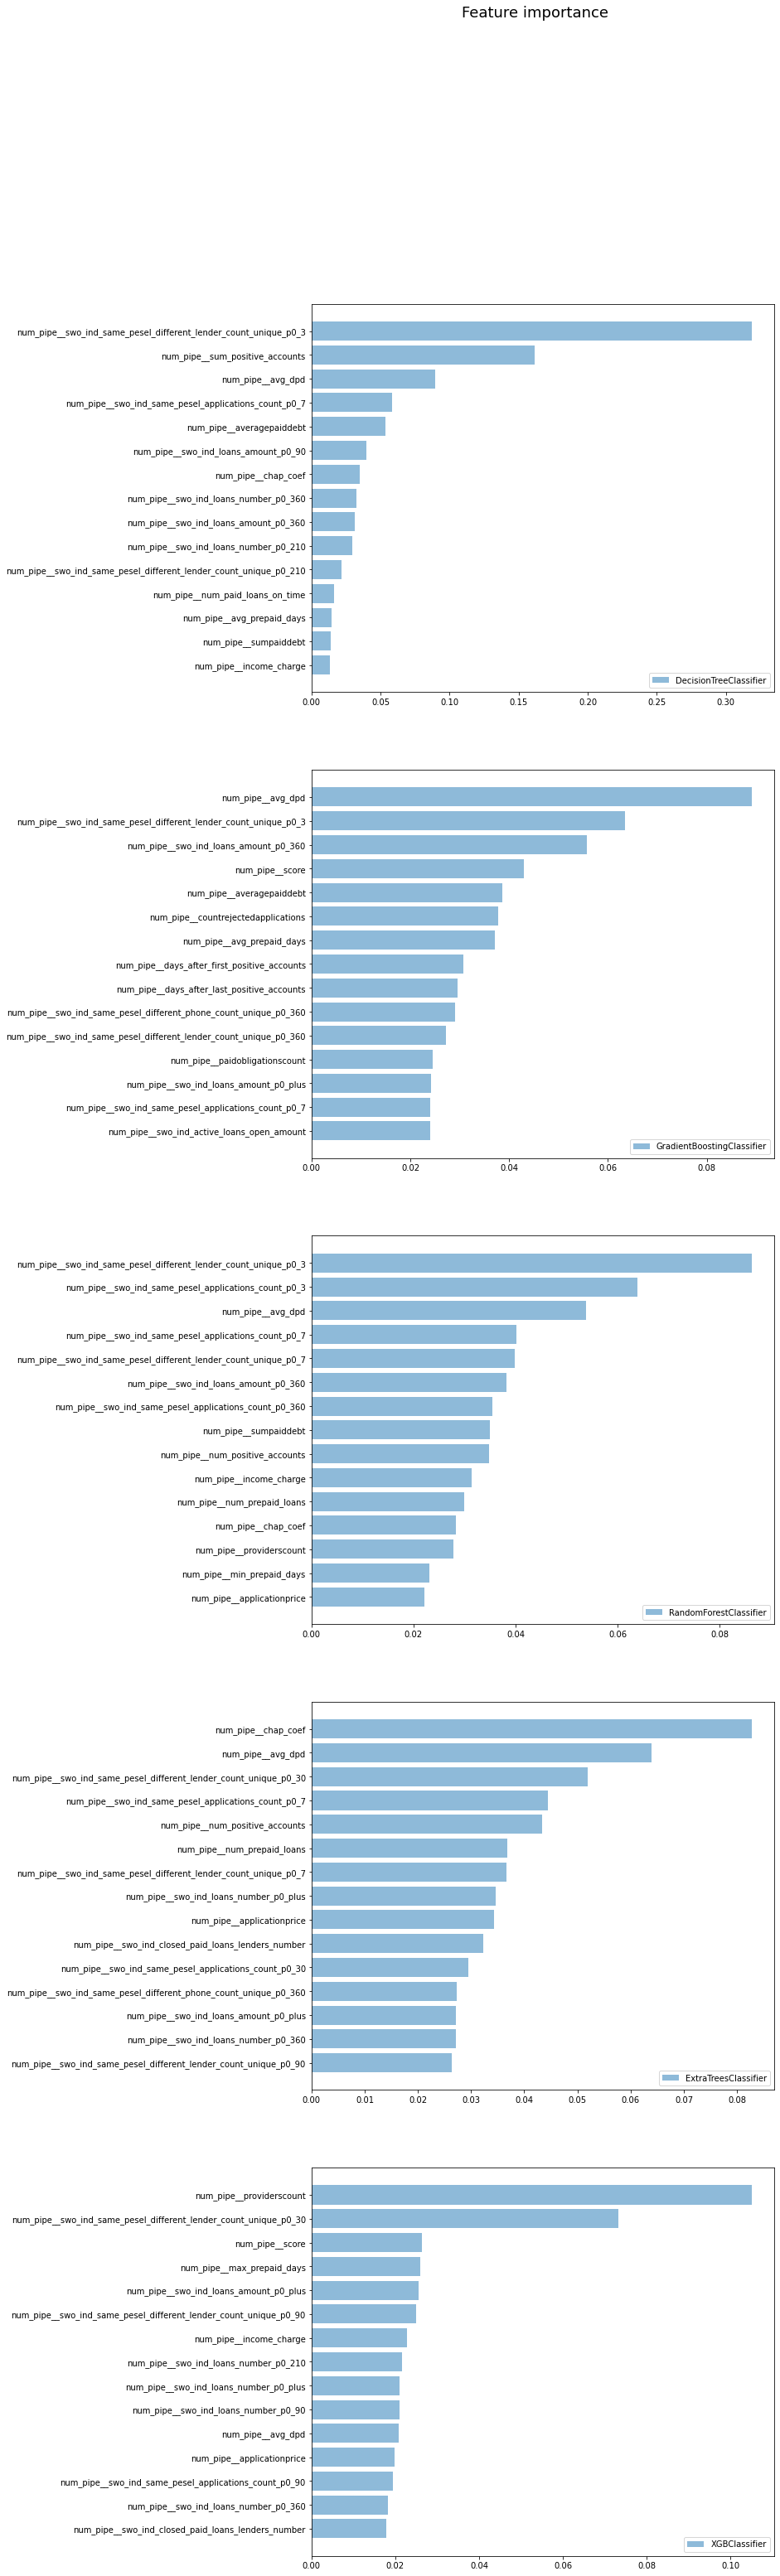

In [75]:
feature_importances_df = pd.DataFrame(data=feature_importances)
fig, axes = plt.subplots(figsize=(10, 50), nrows=len(feature_importances_df.columns[1:]))

i = 0
for col in feature_importances_df.columns[1:]:
    df = feature_importances_df.sort_values(by=col, ascending=True).iloc[-15:,:]
    axes[i].barh(df.feature_names, df[col], align='center', alpha =0.5, label=col)
    axes[i].legend()
    i += 1

fig.suptitle("Feature importance", fontsize=18)

LinearSVC
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GradientBoostingClassifier
RandomForestClassifier
BaggingClassifier
ExtraTreesClassifier
AdaBoostClassifier
XGBClassifier
XGBClassifier
AdaBoostClassifier (ML FLOW)


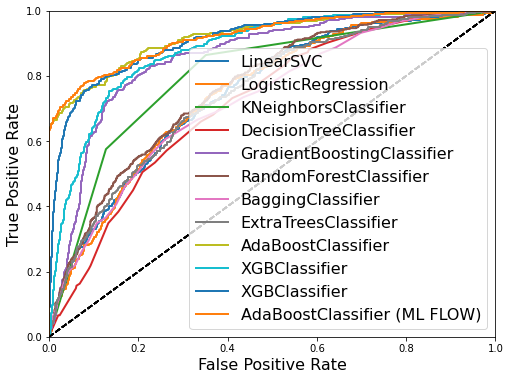

In [76]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
for name, model in models:
    print(name)
    if (name == 'LinearSVC'):
        y_scores = model.decision_function(X_test)
    else: 
        y_scores = model.predict_proba(X_test)[:,1]        
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    plot_roc_curve(fpr, tpr, name)

plt.legend(loc="lower right", fontsize=16)
plt.show()

In [77]:
metrics.confusion_matrix(y_test , adaboostmodel.predict(X_test))

array([[1398,  117],
       [ 111,  374]])

Depending on what we care more about in the classification, we can set threshold. In the following example, we will correct recall score at the expense of precision score:

In [91]:
thr = 0.1
metrics.confusion_matrix(y_test , (adaboostmodel.predict_proba(X_test)[:,1] >= thr).astype(bool))

array([[1323,  192],
       [  96,  389]])

In [95]:
models.append(("AdaBoostClassifier (threshold = 0.1)", adaboostmodel))
precision_score.append(metrics.precision_score(y_test , (adaboostmodel.predict_proba(X_test)[:,1] >= thr).astype(bool)))
recall_score.append(metrics.recall_score(y_test , (adaboostmodel.predict_proba(X_test)[:,1] >= thr).astype(bool)))
f1_score.append(metrics.f1_score(y_test , (adaboostmodel.predict_proba(X_test)[:,1] >= thr).astype(bool)))
accuracy_score.append(metrics.accuracy_score(y_test , (adaboostmodel.predict_proba(X_test)[:,1] >= thr).astype(bool)))
roc_auc_score.append(metrics.roc_auc_score(y_test , (adaboostmodel.predict_proba(X_test)[:,1] >= thr).astype(bool)))        
train_accuracy_score.append(metrics.accuracy_score(y_train , (adaboostmodel.predict_proba(X_train)[:,1] >= thr).astype(bool)))

In [96]:
d = {'test_precision_score': precision_score,
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=[model[0] for model in models])
df.iloc[-2:,:]

,Method,test_precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
11,AdaBoostClassifier (ML FLOW),0.761711,0.771134,0.766393,0.886,0.920702
12,AdaBoostClassifier (threshold = 0.1),0.669535,0.802062,0.729831,0.856,0.837665


# Conclusions

Let me bullet point a few conclusions:
* The solution work with a pretty good total accuracy of 88% and f1-score of 76% for Adaboost Classifier,
* Recall-score, which represents the ratio of people expressed as a percentage that the algorithm predicted would default to the number of people who defaulted was 76%,
* Trees algorithms such as AdaBoost and xgboost achieved the best results. One reason is the lower sensitivity to outliers.

TODO:
* More accurate data preprocessing with examining each explanatory variable separately after obtaining the data documentation,
* An analysis that will show how many people who do not repay debt we can allow to be as profitable as possible.

# Save data

In [78]:
output = pd.DataFrame({'application_id': test_data.application_id, 'TARGET': grid_10.best_estimator_.predict(test_data)})
output.to_csv('output/predict.csv', index = False)

In [79]:
output = pd.DataFrame({'application_id': test_data.application_id, 'TARGET_proba': grid_10.best_estimator_.predict_proba(test_data)[:,1].round(4)})
output.to_csv('output/predict_proba.csv', index = False)